In [1]:
import os
import xml.etree.ElementTree
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk import bigrams
from nltk.tokenize import wordpunct_tokenize
import string
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
#nltk.download()

In [2]:
# Se escapearon los & en el archivo y se agregaron los tags <DOCS> para poder parsearlo como un xml
inputXML = './data/ap/ap.txt'
e = xml.etree.ElementTree.parse(inputXML).getroot()
docs = {}

for elem in e.getchildren():
    text = elem.find('TEXT').text
    docno = elem.find('DOCNO').text.strip()
    docs[docno] = text

#docs

In [3]:
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') +  list(string.punctuation)
vocabulary = {}
bigrams_map = {}

for docno, text in docs.items():
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        tokens = nltk.word_tokenize(sentence)
        
        for bigram in bigrams(tokens):
            if (bigram[0] not in stop_words) and (bigram[1] not in stop_words):
                bigrams_map.setdefault((bigram[0], bigram[1]), 0)
                bigrams_map.setdefault((bigram[1], bigram[0]), 0)
                bigrams_map[bigram[0],bigram[1]] = bigrams_map[bigram[0],bigram[1]] + 1
                bigrams_map[bigram[1],bigram[0]] = bigrams_map[bigram[1],bigram[0]] + 1
        tags = nltk.pos_tag(tokens)
        for word, tag in tags:
            wornet_pos = get_wordnet_pos(tag)
            if wornet_pos:
                lemma = lemmatizer.lemmatize(word, wornet_pos)
            else:
                lemma = lemmatizer.lemmatize(word)
            if lemma not in stop_words:
                vocabulary.setdefault(lemma, 0)
                vocabulary[lemma] = vocabulary[lemma] + 1


In [5]:
print("El tamaño del vocabulario es", len(vocabulary))

El tamaño del vocabulario es 41169


In [6]:
first_500 = list(map(lambda x: x[0], sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)[:500]))
ordered_bigrams = sorted(bigrams_map.items(), key=lambda x: x[1], reverse=True)

for word in first_500:
    for bigram_entry in ordered_bigrams:
        if bigram_entry[0][0] == word:
            print(word, ",", bigram_entry[0][1])
            break


say , officials
`` , I
'' , said
's , It
The , ``
year , last
would , n't
I , ``
percent , 20
He , said
million , shares
n't , ca
people , million
one , said
also , said
government , 's
make , sure
It , ``
U.S. , District
In , ``
two , years
official , said
report , said
last , year
go , would
take , place
But , ``
A , ``
time , first
state , 's
could , n't
Bush , 's
We , ``
include , would
new , The
get , n't
day , one
first , time
tell , n't
Soviet , Union
week , last
New , York
United , States
company , 's
use , drug
call , 's
billion , 1
work , n't
month , last
country , 's
give , would
come , n't
today , said
plan , 's
president , vice
police , said
Thursday , said
American , people
three , years
group , The
States , United
since , time
Tuesday , said
market , stock
member , states
price , bid
President , Bush
issue , The
Monday , said
Friday , said
high , school
force , task
Wednesday , said
They , ``
know , n't
think , I
want , n't
find , n't
begin , would
charge , possession
le

## 2)

In [27]:
punctuation = list(string.punctuation)
tokens = []
with open('./data/on-the-origin-of-species.txt') as file:  
    data = file.read() 
    tokens = list(filter(lambda x: x not in punctuation, nltk.word_tokenize(data)))
    
len(tokens)

209607

In [14]:
words = ['plants', 'instinct', 'for']

def generate_apparitions_vector(word):
    return [i for i, x in enumerate(tokens) if x == word]

In [9]:
std = 50
std_square = std ** 2
twice_std_square = 2 * std_square
denominator = np.sqrt(2 * np.pi) * std

def gaussian(x):
    x_square = x ** 2 
    exp = (-1) * (x_square / twice_std_square) 
    numerator = np.e ** exp
    return numerator / denominator


In [10]:
text_size = len(tokens)
gaussians = {}
for i in range(text_size):
    gaussians[i] = gaussian(i)
    gaussians[-i] = gaussian(-i)

In [48]:
def ro_w(t, apparitions):
    sum = 0
    for i in apparitions:
        sum += gaussians[t - i]
    return sum

def plot_apparitions_from(apparitions):
    a = [ro_w(i, apparitions) for i in range(text_size)]
    plt.plot(a)
    plt.show()
    
    
def calcular_autocorrelacion(tau,apparitions):
    tamanio = text_size - tau

    acum_ro_i = 0
    acum_ro_it = 0
    acum_ro_i_it = 0
    acum_ro_i_2 = 0
    
    for i in range(tamanio):
        ro_i = ro_w(i, apparitions)
        ro_it = ro_w(i+tau, apparitions)

        acum_ro_i += ro_i
        acum_ro_it += ro_it
        acum_ro_i_it += ro_i * ro_it

        acum_ro_i_2 += ro_i ** 2

    prom_ro_i_it = acum_ro_i_it / tamanio
    prom_ro_i = acum_ro_i / tamanio
    prom_ro_it = acum_ro_it / tamanio
    prom_ro_i_2 = acum_ro_i_2 / tamanio
    square_prom_ro_i = prom_ro_i ** 2
    
    autocorrelacion = (prom_ro_i_it - (prom_ro_i * prom_ro_it)) / (prom_ro_i_2 - square_prom_ro_i)
    return autocorrelacion

def plot_autocorrelation_from(apparitions):
    rangos = np.arange(100, 10000, 200) #[10, 50, 100, 250, 500, 750, 1000]

    a = [calcular_autocorrelacion(tao,apparitions) for tao in rangos]
        
    plt.plot(a)
    plt.show()
    
    
def graficos(words):
    for word in words:
        apparitions = generate_apparitions_vector(word)

        plot_apparitions_from(apparitions)
        plot_autocorrelation_from(apparitions)

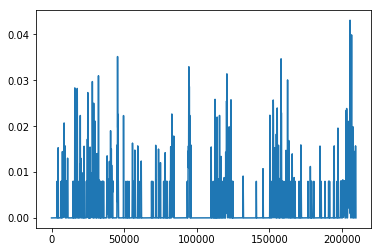

In [ ]:
graficos(words)

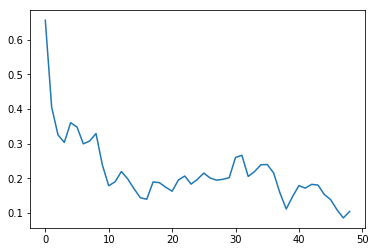

In [47]:
plot_autocorrelation_from(words[1])
        